In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

ship_dir = '../data/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

print(tf.__version__)

2.1.0


In [2]:
# get the image size
image_name = os.listdir('../data/train_v2')[0]
with Image.open(os.path.join('../data/train_v2', image_name)) as img:
    width, height = img.size
    
width, height

(768, 768)

In [3]:
# define params for the model
class Params():
    def __init__(self):
        self.batch_size = 128
        self.epochs = 15
        self.image_size = (768, 768)
        
params = Params()

In [4]:
# read the mask data provided by kaggle
seg = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(seg.shape[0], 'masks found')
print(seg['ImageId'].value_counts().shape[0], 'unique images found')
seg.sample()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
171131,bcfc5624f.jpg,468450 2 469218 3 469986 3 470754 3 471521 4 4...


In [5]:
# identify images that have a mask (ship identification)
def agg_ship_count(seg):
    seg['ship_count'] = seg['EncodedPixels'].map(lambda x: True if isinstance(x, str) else False)
    seg.sample(10)

    # aggregate ship images and sum number of ships
    unique_seg = seg.groupby('ImageId').agg({'ship_count': 'sum'}).reset_index()
    unique_seg['file_size_kb'] = unique_seg['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024 if os.path.exists(os.path.join(train_image_dir, c_img_id)) else 0.0)
    unique_seg = unique_seg[unique_seg['file_size_kb']>50] 
    unique_seg.drop(['file_size_kb'], axis=1, inplace=True)

    unique_seg['has_ship'] = unique_seg['ship_count'].map(lambda x: 1 if x > 0.0 else 0)
    unique_seg['class'] = unique_seg['ship_count'].map(lambda x: 'ship' if x > 0.0 else 'no_ship')

    return unique_seg

train_df = agg_ship_count(pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv')))
train_df.sample(10)

,ImageId,ship_count,has_ship,class
178886,edf155b85.jpg,0.0,0,no_ship
188090,fa272c615.jpg,0.0,0,no_ship
136232,b50841a31.jpg,1.0,1,ship
147814,c49a8543b.jpg,0.0,0,no_ship
61409,51d5672ba.jpg,0.0,0,no_ship
153479,cc1a12def.jpg,0.0,0,no_ship
29490,27264e5d6.jpg,0.0,0,no_ship
109071,90fbd617d.jpg,0.0,0,no_ship
458,00a1aab5b.jpg,2.0,1,ship
85178,7130ff2c8.jpg,0.0,0,no_ship


In [6]:
# Get validation set
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.3,
    stratify = train_df['has_ship']
)

print(train_df.shape[0], 'training samples')
print(valid_df.shape[0], 'validation samples')

133902 training samples
57387 validation samples


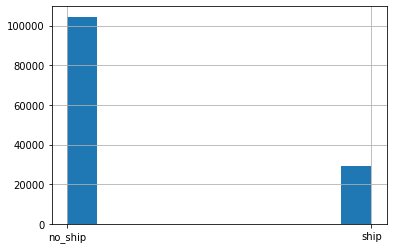

In [7]:
train_df['class'].hist()

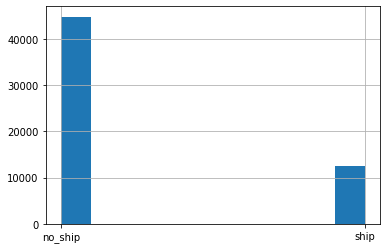

In [8]:
valid_df['class'].hist()

In [36]:
train_image_generator = ImageDataGenerator(rescale=1./255)
valid_image_generator = ImageDataGenerator(rescale=1./255)

In [37]:
train_data_gen = train_image_generator.flow_from_dataframe(
    train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True
)

Found 133902 validated image filenames belonging to 2 classes.


In [38]:
valid_data_gen = valid_image_generator.flow_from_dataframe(
    valid_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True
)

Found 57387 validated image filenames belonging to 2 classes.


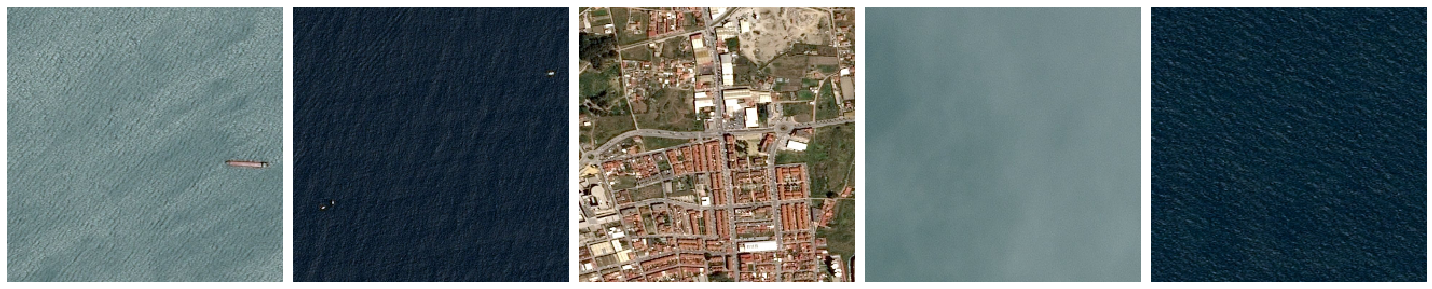

In [39]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:10])

In [40]:
# model
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)            

In [ ]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_df.shape[0] // params.batch_size,
    epochs=params.epochs,
    validation_data=valid_data_gen,
    validation_steps=valid_df.shape[0] // params.batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1046 steps, validate for 448 steps
Epoch 1/15
1046/1046 [==============================] - 342s 327ms/step - loss: 0.4360 - accuracy: 0.7965 - val_loss: 0.3576 - val_accuracy: 0.8335
Epoch 2/15
  97/1046 [=>............................] - ETA: 3:34 - loss: 0.3659 - accuracy: 0.8341